In [1]:
import aprofiles as apro
import numpy as np
import matplotlib.pyplot as plt

#path = "examples/data/E-PROFILE/L2_0-20000-006735_A20210908.nc"
path = "examples/data/E-PROFILE/L2_0-20000-001492_A20210909.nc"
apro_reader = apro.reader.ReadProfiles(path)
profiles = apro_reader.read()

#basic corrections
profiles.extrapolate_below(z=300, inplace=True)
profiles.inversion(verbose=True)

klett : 100%|██████████| 273/273 [00:04<00:00, 57.09it/s]


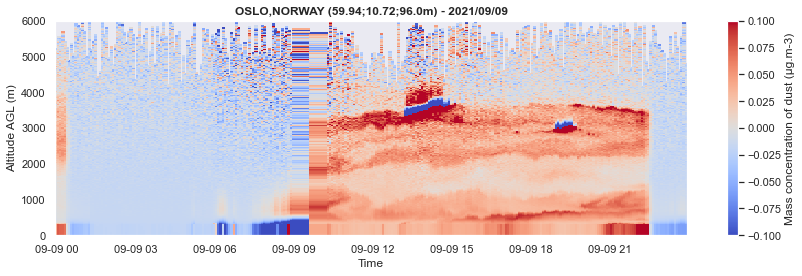

In [4]:
profiles.plot('mass_conc:dust', zmax=6000)